At Episode 50 average steps is 2257.2 (+/-1346.022)
At Episode 100 average steps is 137.6 (+/-59.668)
At Episode 150 average steps is 129.92 (+/-30.207)
At Episode 200 average steps is 116.4 (+/-21.518)
At Episode 250 average steps is 122.72 (+/-21.732)
At Episode 300 average steps is 128.96 (+/-26.297)
At Episode 350 average steps is 118.08 (+/-21.44)
At Episode 400 average steps is 120.0 (+/-27.788)
At Episode 450 average steps is 123.04 (+/-20.318)


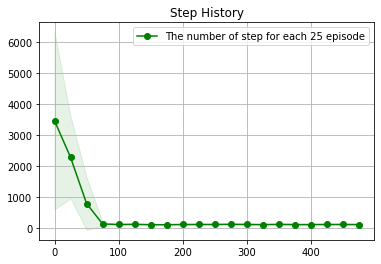

[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0. 

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from collections import defaultdict
import decimal

class State():

    def __init__(self, row=-1, column=-1):
        self.row = row
        self.column = column

    def __repr__(self):
        return "<State: [{}, {}]>".format(self.row, self.column)

    def clone(self):
        return State(self.row, self.column)

    def __hash__(self):
        return hash((self.row, self.column))

    def __eq__(self, other):
        return self.row == other.row and self.column == other.column


class Action(Enum):
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3

class Environment():

    def __init__(self, grid, move_prob=1.0):
        self.grid = grid
        self.agent_state = State()
        self.default_reward = 0
        self.move_prob = move_prob
        self.reset()

    @property
    def row_length(self):
        return len(self.grid)

    @property
    def column_length(self):
        return len(self.grid[0])

    @property
    def actions(self):
        return [Action.UP, Action.DOWN,
                Action.LEFT, Action.RIGHT]

    @property
    def states(self):
        states = []
        for row in range(self.row_length):
            for column in range(self.column_length):
                # Block cells are not included to the state.
                if self.grid[row][column] != 9:
                    states.append(State(row, column))
        return states

    
    def can_action_at(self, state):
        if self.grid[state.row][state.column] == 0 or -1:
            return True
        else:
            return False

    def can_action(self, state, actions):
        can_actions = []
        # Check whether the agent bumped a block cell.
        if self.grid[state.row -1][state.column] != 9:
            can_actions.append(0)
        if self.grid[state.row +1][state.column] != 9:
            can_actions.append(1)
        if self.grid[state.row][state.column -1] != 9:
            can_actions.append(2)
        if self.grid[state.row][state.column +1] != 9:
            can_actions.append(3)
        return can_actions


    def _move(self, state, action):
        if not self.can_action_at(state):
            print(state.row, state.column)
            raise Exception("Can't move from here!")

        next_state = state.clone()

        # Execute an action (move).
        if action == 0:
            next_state.row -= 1
        elif action == 1:
            next_state.row += 1
        elif action == 2:
            next_state.column -= 1
        elif action == 3:
            next_state.column += 1

        # Check whether a state is out of the grid.
        if not (0 <= next_state.row < self.row_length):
            next_state = state
        if not (0 <= next_state.column < self.column_length):
            next_state = state

        # Check whether the agent bumped a block cell.
        if self.grid[next_state.row][next_state.column] == 9:
            next_state = state

        return next_state

    def reward_func(self, state):
        reward = self.default_reward
        done = False

        # Check an attribute of next state.
        attribute = self.grid[state.row][state.column]
        if attribute == -1:
            # Get reward! and the game ends.
            reward = 1
            done = True

        return reward, done

    def reset(self):
        # Locate the agent at lower left corner.
        self.agent_state = State(1, 1)
        return self.agent_state

    def step(self, action):
        next_state, reward, done = self.transit(self.agent_state, action)
        if next_state is not None:
            self.agent_state = next_state

        return next_state, reward, done

    def transit(self, state, action):
        next_state = self._move(state, action)
        reward, done = self.reward_func(next_state)
        return next_state, reward, done


class ELAgent():

    def __init__(self, epsilon):
        self.V = {}
        self.epsilon = epsilon
        self.reward_log = []

    def policy(self, env, s, actions):
        if np.random.random() < self.epsilon:
            return actions[np.random.randint(len(actions))]
        else:
            if len(actions) == 1:
                next_state1 = env._move(s,actions[0])
                return actions[0]
            elif len(actions) == 2:
                next_state1 = env._move(s,actions[0])
                next_state2 = env._move(s,actions[1])
                reward1, done = env.reward_func(next_state1)
                reward2, done = env.reward_func(next_state2)
                if self.V[next_state1]+self.V[next_state2]!= 0:
                    return actions[np.argmax([self.V[next_state1], 
                                              self.V[next_state2]])]                   
                else: 
                    return actions[np.random.randint(len(actions))]     
            elif len(actions) == 3:
                next_state1 = env._move(s,actions[0])
                next_state2 = env._move(s,actions[1])
                next_state3 = env._move(s,actions[2])
                if self.V[next_state1]+self.V[next_state2]+self.V[next_state3] != 0:
                    return actions[np.argmax([self.V[next_state1], 
                                              self.V[next_state2],
                                              self.V[next_state3]])]               
                else: 
                    return actions[np.random.randint(len(actions))] 
            elif len(actions) == 4:
                next_state1 = env._move(s,actions[0])
                next_state2 = env._move(s,actions[1])
                next_state3 = env._move(s,actions[2])
                next_state4 = env._move(s,actions[3])
                if self.V[next_state1]+self.V[next_state2]
                                      +self.V[next_state3]
                                      +self.V[next_state4] != 0:
                    return actions[np.argmax([self.V[next_state1],
                                              self.V[next_state2],
                                              self.V[next_state3],
                                              self.V[next_state4]])]
                else: 
                    return actions[np.random.randint(len(actions))] 
                
            else:
                return actions[np.random.randint(len(actions))]
    def init_log(self):
        self.reward_log = []

    def log(self, reward):
        self.reward_log.append(reward)

    def show_reward_log(self,env, interval=25, episode=-1):
        if episode > 0:
            rewards = self.reward_log[-interval:]
            mean = np.round(np.mean(rewards), 3)
            std = np.round(np.std(rewards), 3)
            print('At Episode {} average steps is {} (+/-{})'
                  .format(episode, mean, std))
        
        else:
            indices = list(range(0, len(self.reward_log), interval))
            means = []
            stds = []
            for i in indices:
                rewards = self.reward_log[i:(i + interval)]
                means.append(np.mean(rewards))
                stds.append(np.std(rewards))
            means = np.array(means)
            stds = np.array(stds)
            plt.figure()
            plt.title('Step History')
            plt.grid()
            plt.fill_between(indices, means - stds, means + stds, 
                             alpha=0.1, color='g')
            plt.plot(indices, means, 'o-', color='g', 
                     label='The number of step for each {} episode'
                     .format(interval))
            plt.legend(loc='best')
            plt.savefig('Step History_{}.png'.format(self.epsilon))
            plt.show()
            K = np.zeros((env.row_length,env.column_length))
            for i in range(0,env.row_length):
                for j in range(0,env.column_length):
                    K[i,j] = decimal.Decimal(self.V[State(i,j)])
                    .quantize(decimal.Decimal("0.001"))
            print(K) 
class TD(ELAgent):

    def __init__(self, epsilon=0.5):
        super().__init__(epsilon)

    def learn(self, env, episode_count, gamma=0.95, learning_rate=0.05,
              report_interval=50):
        self.init_log()
        self.V = defaultdict(lambda: 0)
        actions = list(range(4))
        for e in range(episode_count):
            s = env.reset()
            done = False
            count = 0
            while not done:
                can_actions = env.can_action(s, actions)
                a = self.policy(env, s, can_actions)
                n_state, reward, done = env.step(a)
                gain = reward + gamma * (self.V[n_state])
                estimated = self.V[s]
                self.V[s] += learning_rate * (gain - estimated)
                s = n_state
                count += 1

            else:
                self.log(count)

            if e != 0 and e % report_interval == 0:
                self.show_reward_log(env,episode=e)
    

def train():
#     grid = [
#     [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
#     [9, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 9],
#     [9, 0, 0, 9, 0, 9, 0, 0, 9, 9, 0, 9],
#     [9, 9, 0, 9, 0, 9, 9, 9, 9, 0, 0, 9],
#     [9, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 9],
#     [9, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 9],
#     [9, 9, 9, 9, 9, 0, 9, 0, 9, 0, 0, 9],
#     [9, 0, 0, 0, 0, 0, 9, 0, 9, 0, 0, 9],
#     [9, 0, 9, 9, 9, 9, 9, 0, 9, 0, 0, 9],
#     [9, 0, 0, 0, 0, 9, 0, 0, 9, 0, 0, 9],
#     [9, 0, 0, 9, 0, 0, 0, 0, 9, 0, -1, 9],
#     [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]]
    grid = [
    [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
    [9, 0, 0, 9, 0, 0, 0, 0, 0, 9, 0, 0, 9, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 9],
    [9, 0, 0, 9, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 9, 0, 0, 9, 0, 0, 9],
    [9, 9, 0, 9, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 0, 9, 0, 9, 0, 0, 9, 0, 0, 9],
    [9, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 9, 0, 9, 0, 0, 9, 0, 0, 9],
    [9, 0, 9, 9, 9, 9, 0, 0, 9, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 9],
    [9, 0, 0, 0, 0, 9, 9, 0, 9, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 9, 9],
    [9, 0, 0, 0, 0, 9, 0, 0, 9, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9],
    [9, 9, 9, 9, 9, 9, 0, 9, 9, 9, 0, 0, 0, 9, 0, 9, 9, 0, 0, 0, 0, 0, 0, 9],
    [9, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 9, 0, 9, 0, 9 ,9 ,0, 9, 9, 9, 9, 9 ,9],
    [9, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 9, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9],
    [9, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 9, 0, 9, 0, 0, 0, 9],
    [9, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 9],
    [9, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9],
    [9, 0, 0, 9, 0, 0, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9],
    [9, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 9],
    [9, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 9, 0, 0, 0, 0, 0, 0, 9, 9, 9, 0, 0, 9],
    [9, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 0, 0, 9],
    [9, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 9, 0, 0, 0, 0, 9, 9, 9, 0, 0, 9],
    [9, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9],
    [9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9],
    [9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0 ,0 ,0, 0, 0, 0, 0, 0, 9],
    [9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 9, 0, 0, 0, 9, 0, 0, 9, 9, 9, 9, 9, 9, 9],
    [9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 9],
    [9, 0, 0, 0, 0, 0, 0, 9, 9, 0, 0, 0, 0, 0, 9, 0 ,0 ,0, 9, 0, 0, 0, -1, 9],
    [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
    ]
   

    env = Environment(grid)
    row_length = env.row_length
    column_length = env.column_length
    agent = TD()
    agent.learn(env, episode_count=500)
    agent.show_reward_log(env)

if __name__ == '__main__':
    train()